## Rule based Control Simulation for components sizing

Used in sizing the component of the solar home

In [1]:
# Import modules to be used
using  CSV, PyPlot, DataFrames, DelimitedFiles, PyCall

import BaseHEMS,TypesHEMS #My own module in folder Mdl_and_Fct

import Statistics

np = pyimport("numpy");# Import python numpy

┌ Info: Precompiling BaseHEMS [top-level]
└ @ Base loading.jl:1278


### Import data to be used for the problem

In [2]:
nbday2load = 5 # Numbers days to load:5
K = 48*nbday2load |> Int ; # Problem horizon::Integer 
                           # With Δₜ = 0.5 (30mn) each day is subdivided into 48(24/0.5) periods.
firstRow = 7346;  #2011-12-05 00:00:00; #First row to load.
lastRow = K; #2011-12-05 00:00:00,

fixVars = BaseHEMS.initFixedVars() # Initialized fixed variables 

#Load data from row firstRow to lastRow (add a "-1" if one wants 
# the last day element considered to be at 23:30:00 )
data = DataFrame!(CSV.File("/home/supelec/My_Jupiter/GitJupLab/JuliaMyLOve/data_2011-2012.csv";
    skipto=firstRow, limit=lastRow));

# Get data in 1D vector form
Pl_star = data.GC;
Pv_star = data.GG*fixVars.Pv_max/1.04;

Pnl = Pl_star - Pv_star;

Cgr = BaseHEMS.hp_hc(nbday2load+3,[0 6]); # Energy cost over the horizon defined by Figure 4.4

t = range(0,(K/2) - fixVars.dt,step=fixVars.dt)/24; # Range of problem Horizon converted in days


### Run the rulebased HEMS controller 


In [3]:
ctrlVars, Eb = BaseHEMS.ruleBasedControl(copy(Pl_star),Pv_star);

###  Set the plot input

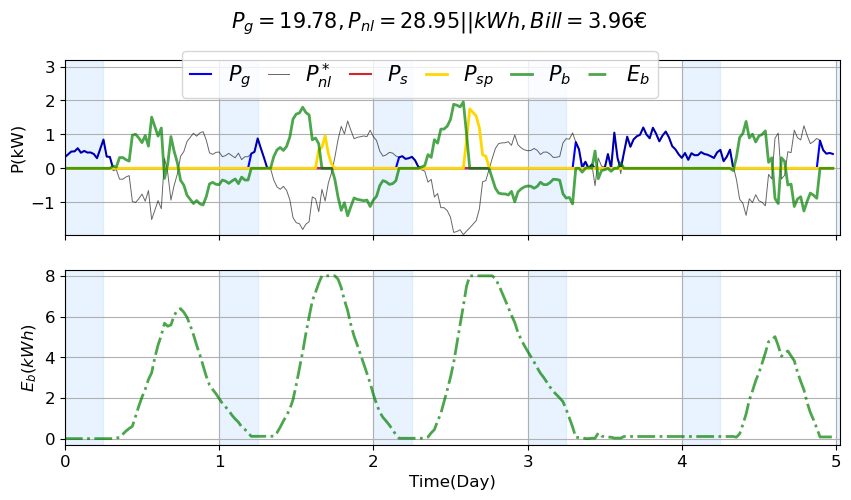

In [4]:
plotInput = TypesHEMS.solvedProbData(t,K,nbday2load,ctrlVars,Eb,Pl_star,Pv_star);

BaseHEMS.setPlotFonts("12","12") # Set plot font size

BaseHEMS.plot_solHomRslt(plotInput;fig_size=(10,5)); # Plot data

### Import data for 100 days of traning set

In [5]:
nbday2load = 100 # Numbers days to load
K = 48*nbday2load |> Int ; # Problem horizon::Integer 
                           # With Δₜ = 0.5 (30mn) each day is subdivided into 48(24/0.5) periods.
firstRow = 7346;  #2011-12-05 00:00:00; #First row to load.
lastRow = K; #2011-12-05 00:00:00,

fixVars = BaseHEMS.initFixedVars() # Initialized fixed variables 

#Load data from row firstRow to lastRow (add a "-1" if one wants 
# the last day element considered to be at 23:30:00 )
data = DataFrame!(CSV.File("/home/supelec/My_Jupiter/GitJupLab/JuliaMyLOve/data_2011-2012.csv";
    skipto=firstRow, limit=lastRow));

# Get data in 1D vector form
Pl_star = data.GC;
Pv_star = data.GG*fixVars.Pv_max/1.04;

Pnl = Pl_star - Pv_star;

Cgr = BaseHEMS.hp_hc(nbday2load+3,[0 6]); # Energy cost over the horizon defined by Figure 4.4

t = range(0,(K/2) - fixVars.dt,step=fixVars.dt)/24; # Range of problem Horizon converted in days


### Showings statistics based on the training set

In [6]:
PL = sum(reshape(Pl_star, 48,: ),dims=1)*0.5
PV = sum(reshape(Pv_star, 48,: ),dims=1)*0.5
PNL= sum(reshape(Pnl, 48,: ),dims=1)*0.5
tabb = [PL, PV, PNL]
trnSet = ["P_{l} \t", "P_{v} \t", "P_{nl} \t",]

println("---  Statistics about training set ---")
println("--------------------------------------")
println("-------  Mean   ------   Var  --------")

i=0
for elm in tabb
    println(trnSet[i+=1], round( Statistics.mean(elm), digits=2),"\t------\t",
                   round(Statistics.var(elm), digits=2),"  --------")
end

---  Statistics about training set ---
--------------------------------------
-------  Mean   ------   Var  --------
P_{l} 	17.64	------	3.59  --------
P_{v} 	11.64	------	21.72  --------
P_{nl} 	6.0	------	26.91  --------


### Perform sensitivity analysis on Eb_max and Pv_max

In [7]:
EBMax = 20;
PVMax = 6; 

# sensivity analisis with Eb_max and Pv_max
nrows = length(0:0.5:20);
ncols = length(0:0.10:6);

# set the hourly energy cost to a cst 
Cgr[1:K] .= 0.2;

PG = zeros(nrows,ncols);  PW = zeros(nrows,ncols); 
PB = zeros(nrows,ncols);  EB = zeros(nrows,ncols);  COUT_cons = zeros(nrows,ncols);

ro=1; 
co=1;

for Eb_m in EBMax:-0.5:0 # move from the higher to the lower storage 
    co=1; #reset to the first one after each end of the second loop
    
    for Pv_m in 0:0.1:PVMax
        
        #Update the solar production
        Pv_star = data.GG*Pv_m/1.04;
        
        fixedVar= BaseHEMS.initFixedVars(Eb_max=Eb_m) #Init Fixed var; 
        
        ctrlVars, Eb = BaseHEMS.ruleBasedControl(copy(Pl_star),Pv_star,fixedVar);# apply the Rulebased 
                                                                                 # controller
        ctrlVarsSum = BaseHEMS.initControledVars(ctrlVars);
        
        # save the mean over the numbers days of simulation
        PG[ro,co] = ctrlVarsSum.Pg_t/(nbday2load);
        PW[ro,co] = ctrlVarsSum.Pw_t/nbday2load;
        COUT_cons[ro,co] = ctrlVarsSum.Cost_t/nbday2load;

        co+=1;#increment co to go to the next collumn.
    end
    
    ro+=1;
    #print(ro)
end
        

### Plot grid energy given the sensitivity analisis

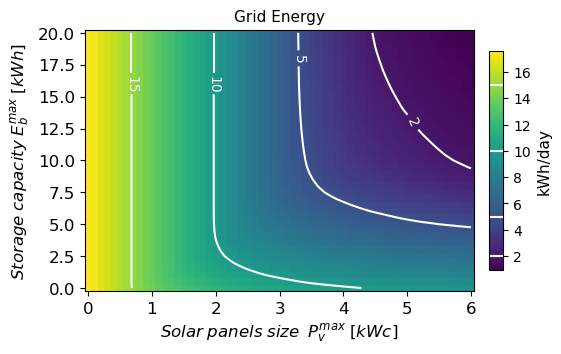

In [8]:
fig,ax = subplots(figsize=(5.4,6))

BaseHEMS.setPlotFonts(10,11,11)

figg = ax.imshow(PG)

clbar =colorbar(figg, aspect=15,fraction = 0.035,pad=0.035,ticks=0:2:18)
cntr = contour(PG,[2,5,10,15], colors="w")
clabel(cntr,fmt="%1.0f",colors="w",inline_spacing=10)
clbar.set_label("kWh/day")
xlabel(L"Solar\; panels\; size\;\;P_{v}^{max}\;[kWc]")
ylabel(L"Storage\; capacity\; E_b^{max}\;[kWh]")
clbar.add_lines(cntr)
xticks(0:10:60,0:6);
yticks(0:5:40,20:-2.5:0);
title("Grid Energy");

### Plot Pv energy wasted given the sensitivity analisis

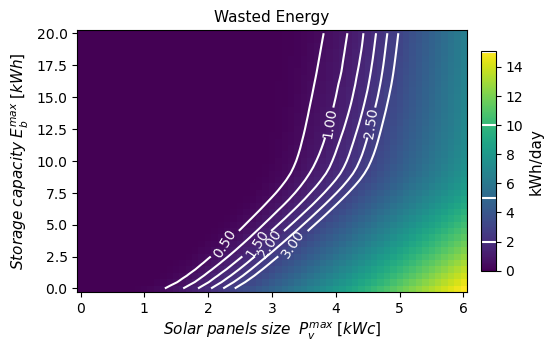

PyObject Text(0.5, 1.0, 'Wasted Energy')

In [9]:
fig,ax = subplots(figsize=(5.4,6))

figg=ax.imshow(PW)

clbar=colorbar(figg,aspect=15,fraction = 0.035,pad=0.035,ticks=0:2:18)
cntr1= contour(PW,0.5:0.5:3, colors="w")
clabel(cntr1,fmt="%1.2f",colors="w",inline_spacing=10)
clbar.set_label("kWh/day")
xlabel(L"Solar\; panels\; size\;\;P_{v}^{max}\;[kWc]")
ylabel(L"Storage\; capacity\; E_b^{max}\;[kWh]")
clbar.add_lines(cntr)
xticks(0:10:60,0:6);
yticks(0:5:40,20:-2.5:0);
title("Wasted Energy")

### Compute and plot the investement cost for each pair of values (Pv_max, Eb_max)

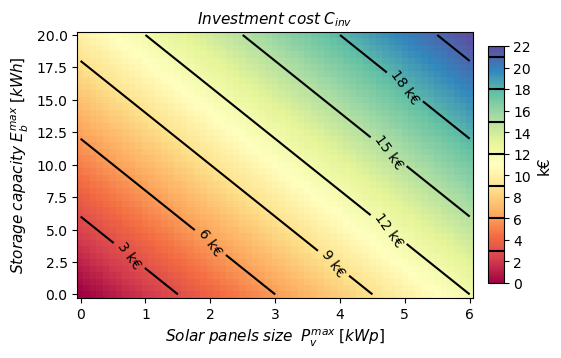

In [10]:
yy = EBMax:-0.5:0; 
xx = 0:0.1:PVMax; 

yy= yy*500 #500€ the cost of a storage of 1kWh
xx = xx*2000; # 2000€ the cost of a solar panel  of 1kWp

X,Y = np.meshgrid(xx,yy)
C_inv = X+Y;

fig,ax = subplots(figsize=(5.5,6))

figg=ax.imshow(C_inv/1000,cmap= "Spectral")
clbar=colorbar(figg,aspect=15,fraction=0.037,pad=0.035,ticks=(0:2:35))
clbar.set_label("k€")
cntr = contour(C_inv/1000,colors="k",3:3:24)
clabel(cntr, fmt="%1.0f k€",  colors="k",inline_spacing=10)
clbar.add_lines(cntr)
xlabel(L"Solar\; panels\; size\;\;P_{v}^{max}\;[kWp]")
ylabel(L"Storage\; capacity\; E_b^{max}\;[kWh]")
xticks(0:10:60,0:6);
yticks(0:5:40,20:-2.5:0);
title(L"Investment\; cost\;  C_{inv}");

### Compute the investement + operational cost  for each pair of values (Pv_max, Eb_max)

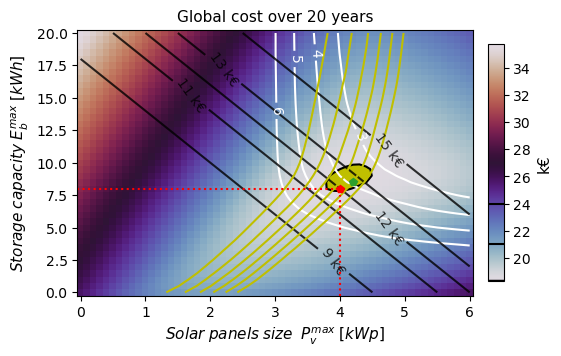

In [11]:
T_life = 20; 
C_glob = C_inv + COUT_cons*365*T_life # dayly consumtion*365*20years

fig,ax = subplots(figsize=(5.5,6))

figg=ax.imshow(C_glob/1000,cmap= "twilight")

clbar=colorbar(figg,aspect=15,fraction=0.037,pad=0.035,ticks=(0:2:40))
clbar.set_label("k€")
clbar.set_ticklabels(0:2:40)
cnrt= contour( C_glob/1000,18.4:0.1:18.4, colors="k")
cnrt= contourf( C_glob/1000,18.2:0.1:18.4,colors="y")
clbar.add_lines(cntr)
#clabel(cnrt,fmt="%2.3f",colors="k")
xlabel(L"Solar\; panels\; size\;\;P_{v}^{max}\;[kWp]")
ylabel(L"Storage\; capacity\; E_b^{max}\;[kWh]")
plot(40,24,color="red",marker="p")

cntr= contour(PG,[3,4,5,6,], colors="w")
clabel(cntr,fmt="%1.0f",colors="w",inline_spacing=10)

cntr = contour( C_inv/1000,colors="k",[9,11,12,13,15],alpha=0.8)
clabel(cntr, fmt="%1.0f k€",  colors="k",inline_spacing=10)

cntr1= contour(PW,0.5:0.5:3, colors="y")


~,b = findmin(C_glob)

plot(b[2],b[1],color="Tab:green",marker="p")

axvline(b[2]-2,ymax=0.38,ls=":",color="red")
axhline(24,xmax=0.65,ls=":",color="red")

xticks(0:10:60,0:6);
yticks(0:5:40,20:-2.5:0);
title("Global cost over 20 years");